In [8]:
import numpy as np
import pandas as pd
import networkx as nx 
import random
import matplotlib.pyplot as plt
import scipy

np.random.seed(1)
random.seed(1)

Functions that will be used:


In [9]:
def one_iteration(G, gamma, beta) : 
    list_healthy = []
    list_infected = []
    # Maybe there is abetter way to do that
    for node, attribute in nx.get_node_attributes(G, "Status").items() : 
        if attribute == "Infected" : 
            list_infected.append(node)
        else : list_healthy.append(node)
    
    # CREATE A LIST WITH THE INFECTED NODES THAT WILL RECOVER IN THIS STEP
    list_recovered = []
    for i in list_infected : 
        if random.uniform(0,1) < gamma : 
            list_recovered.append(i)

    # CREATE A LIST WITH THE HEALTHY NODES THAT WILL BE INFECTED IN THIS STEP
    for i in list_healthy : 
        neighbours_infected = [v for v in nx.neighbors(G, i) if G.nodes[v]["Status"] == "Infected"]
        if not (random.uniform(0,1) < pow((1-beta),len(neighbours_infected))) :
            G.nodes[i]["Status"] = "Infected" # (instead of creating a list we directly change their status)
    
    # UPDATE STATUS FOR THE NODES RECOVERED
    for i in list_recovered : 
        G.nodes[i]["Status"] = "Susceptible"

    # GET THE LISTS OF INFECTED AND SUSCEPTIBLE PEOPLE
    list_infected = [u for (u,d) in nx.get_node_attributes(G, "Status").items() if d == 'Infected']
    list_healthy = [u for (u,d) in nx.get_node_attributes(G, "Status").items() if d == 'Susceptible']
    return G # , list_infected, list_healthy

We set the parameters of the model and create the netwroks:

In [10]:
# Parameters
total_pop = 1000
p_0 = 0.01
gamma = 0.1 # recovery rate
beta_vec = [0.00005, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.004, 0.005, 0.006, 0.01, 0.02, 0.04, 0.05, 0.1, 0.2]
# beta = 0.025 # infection rate
t_max = 100

# Networks to be studied 
G_Kn = nx.complete_graph(total_pop)
G_BA = nx.barabasi_albert_graph(total_pop, m = 5, seed = 1)
G_WS = nx.watts_strogatz_graph(total_pop, k = 4, p = 0.2, seed = 1)
# G_tree = nx.tree_graph(total_pop, seed = 1)
# G_star = nx.star_graph(total_pop, seed = 1)
# G_lattice = nx.latt
G_ER = nx.erdos_renyi_graph(total_pop, p = 0.25, seed = 1) # SHOULD CHANGE P TO SOMETHING THAT IS LESS CONNECTED. 




Set the status of each node at time 0

In [11]:
# At first all the population is helathy
nx.set_node_attributes(G_Kn, "Susceptible", "Status")
nx.set_node_attributes(G_BA, "Susceptible", "Status")
nx.set_node_attributes(G_WS, "Susceptible", "Status")
nx.set_node_attributes(G_ER, "Susceptible", "Status")

# Choose the nodes that will be infected at the begining
infected_0 = np.random.choice(total_pop, int(p_0*total_pop), replace=False)

# infected_0
# G_Kn.nodes(data =True)
# G_BA.nodes(data =True)
# G_WS.nodes(data =True)
# G_ER.nodes(data =True)

# Change the status of those nodes to infected
for i in infected_0 : 
    G_Kn.nodes[i]["Status"] = "Infected"
    G_BA.nodes[i]["Status"] = "Infected"
    G_WS.nodes[i]["Status"] = "Infected"
    G_ER.nodes[i]["Status"] = "Infected"

G_Kn_0 = G_Kn.copy()
G_BA_0 = G_BA.copy()
G_WS_0 = G_WS.copy()
G_ER_0 = G_ER.copy()


# In case we want to check it works
# infected_neightbour_i = len([v for v in nx.neighbors(G_Kn, 0) if G_Kn.nodes[v]["Status"] == "Infected"])
# infected_neightbour_i = len([v for v in nx.neighbors(G_BA, 0) if G_BA.nodes[v]["Status"] == "Infected"])
# infected_neightbour_i = len([v for v in nx.neighbors(G_WS, 0) if G_WS.nodes[v]["Status"] == "Infected"])
# infected_neightbour_i = len([v for v in nx.neighbors(G_ER, 0) if G_ER.nodes[v]["Status"] == "Infected"])
# infected_neightbour_i

Code that computes the epidemic:

In [12]:
# Create DataFrames and save situation at time 0
list_iter = [*range(t_max+1)]

df_Kn = pd.DataFrame(columns= list_iter)
df_BA = pd.DataFrame(columns= list_iter)
df_WS = pd.DataFrame(columns= list_iter)
df_ER = pd.DataFrame(columns= list_iter)
df_Kn['0'] = nx.get_node_attributes(G_Kn,"Status").values()
df_BA['0'] = nx.get_node_attributes(G_BA,"Status").values()
df_WS['0'] = nx.get_node_attributes(G_WS,"Status").values()
df_ER['0'] = nx.get_node_attributes(G_ER,"Status").values()


for beta in beta_vec : 
    # Reset Default values
    G_Kn = G_Kn_0.copy()
    G_BA = G_BA_0.copy()
    G_WS = G_WS_0.copy()
    G_ER = G_ER_0.copy()

    # Iterate trought time 
    for i in range(t_max) : # We will stop at t_max = 100 which should be enough considering our networks are of the size of 1000 nodes 
        # Simulates one step
        G_Kn = one_iteration(G_Kn, gamma, beta)
        G_BA = one_iteration(G_BA, gamma, beta)
        G_WS = one_iteration(G_WS, gamma, beta)
        G_ER = one_iteration(G_ER, gamma, beta)
        # Save the results of the step in the DataFrames
        df_Kn[str(i+1)] = nx.get_node_attributes(G_Kn,"Status").values()
        df_BA[str(i+1)] = nx.get_node_attributes(G_BA,"Status").values()
        df_WS[str(i+1)] = nx.get_node_attributes(G_WS,"Status").values()
        df_ER[str(i+1)] = nx.get_node_attributes(G_ER,"Status").values()

    df_Kn.to_csv("beta_" + str(beta) + "-Simulation_Kn.csv", index = False)
    df_BA.to_csv("beta_" + str(beta) + "-Simulation_BA.csv", index = False)
    df_WS.to_csv("beta_" + str(beta) + "-Simulation_WS.csv", index = False)
    df_ER.to_csv("beta_" + str(beta) + "-Simulation_ER.csv", index = False)


C:\Users\lluis\AppData\Local\Temp\ipykernel_1728\1191626238.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_Kn[str(i+1)] = nx.get_node_attributes(G_Kn,"Status").values()
C:\Users\lluis\AppData\Local\Temp\ipykernel_1728\1191626238.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_BA[str(i+1)] = nx.get_node_attributes(G_BA,"Status").values()
C:\Users\lluis\AppData\Local\Temp\ipykernel_1728\1191626238.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many 

With the previous block of code we have create several DataFrames. The following blocks will create the plots corresponding.

In [11]:
# Modify data to be shown
# df_Kn.replace(to_replace="Susceptible", value = 0, inplace = True)
# df_Kn.replace(to_replace="Infected", value = 1, inplace = True)
# df_Kn.replace(to_replace=0, value = "Susceptible", inplace = True)
# df_Kn.replace(to_replace=1, value = "Infected", inplace = True)

# Read files in case is not computed previously
df_Kn = pd.read_csv("beta_" + str(beta) + "-Simulation_Kn.csv")
df_BA = pd.read_csv("beta_" + str(beta) + "-Simulation_BA.csv")
df_WS = pd.read_csv("beta_" + str(beta) + "-Simulation_WS.csv")
df_ER = pd.read_csv("beta_" + str(beta) + "-Simulation_ER.csv")


df_plot_Kn = df_Kn.apply(pd.Series.value_counts).transpose() 
df_plot_BA = df_BA.apply(pd.Series.value_counts).transpose()
df_plot_WS = df_WS.apply(pd.Series.value_counts).transpose()
df_plot_ER = df_ER.apply(pd.Series.value_counts).transpose()


In [12]:
df_plot = pd.concat([df_plot_Kn, df_plot_BA, df_plot_WS, df_plot_ER], axis = 1)
df_plot.drop(df_plot.columns[[1, 3, 5, 7]], axis=1, inplace=True)
df_plot.reset_index(inplace=True)
df_plot.set_axis(['Time', 'Kn', 'BA', 'WS', 'ER'], axis='columns', inplace=True)

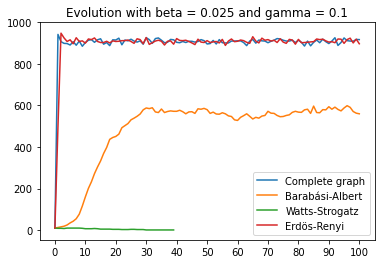

In [14]:
plt.plot(df_plot["Time"], df_plot["Kn"], label = "Complete graph")
plt.plot(df_plot["Time"], df_plot["BA"], label = "Barabási-Albert")
plt.plot(df_plot["Time"], df_plot["WS"], label = "Watts-Strogatz")
plt.plot(df_plot["Time"], df_plot["ER"], label = "Erdös-Renyi")
plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
plt.yticks([0,200,400,600,800,1000])
plt.title("Evolution with beta = " + str(beta) + " and gamma = " + str(gamma))
plt.legend()
plt.show()

Study of the Eigenvalues

In [15]:
max_eigen = {'Kn': 0,'BA': 0,'WS': 0,'ER': 0}
max_eigen['Kn'] = max(nx.adjacency_spectrum(G_Kn))
max_eigen['BA'] = max(nx.adjacency_spectrum(G_BA))
max_eigen['WS'] = max(nx.adjacency_spectrum(G_WS))
max_eigen['ER'] = max(nx.adjacency_spectrum(G_ER))
max_eigen

c:\Users\lluis\anaconda3\lib\site-packages\networkx\linalg\spectrum.py:110: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return sp.linalg.eigvals(nx.adjacency_matrix(G, weight=weight).todense())


{'Kn': (999.0000000000058+0j),
 'BA': (19.667384832947985+0j),
 'WS': (4.2918319389779445+0j),
 'ER': (251.08841165595697+0j)}